## Intro to information extraction from text

All of the data we've looked at so far has been *structured*, meaning essentially that the data looked like a table or Excel spreadsheet. Not all data looks like that, however.  Human readable text is an extremely common *unstructured* data source.  From the text of a webpage, tweet, or document, businesses want to perform things like:

* sentiment analysis
* document summarization
* document clustering
* document recommendation

In MSAN 692, data acquisition, we'll learn how to extract the text from webpages or pieces of webpages such as the bestseller list at Amazon. For now, we can play with some prepared text files.

Text analysis uses words as data rather than numbers, which means *tokenizing* text; i.e., splitting the text string for a document into individual words. This problem is actually much harder than you might think.  For example, if we split the document text on the space character, then "San Francisco" would be split into two words.  For our purposes here, that'll work just fine. See [Tokenization in this excellent information retrieval book](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) for more information.

<img src="images/wordcloug.png" style="width:200px" align="right">The goal of this lecture-lab is to get familiar with tokenizing text and how to extract some basic data, such as word frequency. To do that, we're going to learn about *tuples*, *associations*, and *dictionaries*. To visualize information extracted from a document, we'll use *word clouds* like the image to the right that emphasize words according to their frequency.

Let's get started by examining the machinery needed to compute word frequencies.

## Support code

Ignore. This is just so that I can use my fun little list of list visualizers in this lecture.

In [78]:
import graphviz

def dictviz(d):
    s = """
    digraph G {
        nodesep=.05;
        rankdir=LR;
        node [penwidth="0.5", shape=record,width=.1,height=.1];
    """
    labels = []
    for key,value in d.items():
        labels.append("%s&rarr;%s" % (repr(key),elviz(value,True)))
    s += '    mainlist [color="#444443", fontsize="9", fontcolor="#444443", fontname="Helvetica", style=filled, fillcolor="#FBFEB0", label = "'+'|'.join(labels)+'"];\n'
    s += '}\n'
    return graphviz.Source(s)


def listviz(elems, showassoc=True):
    s = """
    digraph G {
        nodesep=.05;
        node [penwidth="0.5", shape=record,width=.1,height=.1];
    """
    if type(elems)==dict:
        return dictviz(elems)

    labels = []
    for i in range(len(elems)):
        el = elems[i]
        if not el:
            labels.append(str(i))
        else:
            labels.append(idx_elviz(i,el,showassoc))
    s += '    mainlist [space="0.0", margin="0.01", fontcolor="#444443", fontname="Helvetica", label=<'+'|'.join(labels)+'>];\n'

    s += "}\n"
    return graphviz.Source(s)


def lolviz(table, showassoc=True):
    """
    Given a list of lists such as:
      [ [('a','3')], [], [('b',230), ('c',21)] ]
    return the dot/graphviz to display as a two-dimensional
    structure.
    If showassoc, display 2-tuples (x,y) as x->y.
    """
    def islol(table):
        for x in table:
            if type(x)==list or type(x)==tuple:
                return True
        return False

    if not islol(table):
        return listviz(table, showassoc)

    s = """
    digraph G {
        nodesep=.05;
        rankdir=LR;
        node [penwidth="0.5", shape=record,width=.1,height=.1];
    """
    # Make outer list as vertical
    labels = []
    for i in range(len(table)):
        # if (type(bucket)==list or type(bucket)==tuple) and len(bucket) == 0:
        #     labels.append(str(i))
        # else:
        #     labels.append("<f%d> %d" % (i, i))
        labels.append("<f%d> %d" % (i, i))

    s += '    mainlist [color="#444443", fontsize="9", fontcolor="#444443", fontname="Helvetica", style=filled, fillcolor="#D9E6F5", label = "'+'|'.join(labels)+'"];\n'

    # define inner lists
    for i in range(len(table)):
        bucket = table[i]
        if bucket==None:
            continue
        elements = []
        if (type(bucket)==list or type(bucket)==tuple) and len(bucket) == 0:
            s += 'node%d [margin="0.03", fontname="Italics", shape=none label=<<font color="#444443" point-size="9">empty list</font>>];\n' % i
        else:
            if type(bucket)==list or type(bucket)==tuple:
                if len(bucket)>0:
                    for j, el in enumerate(bucket):
                        elements.append(idx_elviz(j, el, showassoc))
            else:
                elements.append(elviz(bucket, showassoc))
            s += 'node%d [color="#444443", fontname="Helvetica", margin="0.01", space="0.0", shape=record label=<{%s}>];\n' % (i, '|'.join(elements))

    # Do edges
    for i in range(len(table)):
        bucket = table[i]
        if bucket==None:
            continue
        # if not bucket or ((type(bucket)==list or type(bucket)==tuple) and len(bucket)==0):
        #     continue
        s += 'mainlist:f%d -> node%d [penwidth="0.5", color="#444443", arrowsize=.4]\n' % (i,i)
    s += "}\n"
    # print s
    return graphviz.Source(s)


def elviz(el, showassoc):
    if showassoc and type(el) == tuple and len(el) == 2:
        els = "%s&rarr;%s" % (elviz(el[0], showassoc), elviz(el[1], showassoc))
    elif type(el)==set:
        els = '{'+', '.join([elviz(e, showassoc) for e in el])+'}'
    elif type(el) == dict:
        els = '{' + ','.join([elviz(e, showassoc) for e in el.items()]) + '}'
    else:
        els = repr(el)
    els = els.replace('{', '&#123;')
    els = els.replace('}', '&#125;')
    return els


def idx_elviz(idx, el, showassoc):
    return \
        """
        <table BORDER="0" CELLBORDER="1" CELLSPACING="0">
          <tr>
            <td cellspacing="0" bgcolor="#FBFEB0" border="1" sides="b" valign="top"><font color="#444443" point-size="9">%d</font></td>
          </tr>
          <tr>
            <td bgcolor="#FBFEB0" border="0" align="center"><font point-size="11">%s</font></td>
          </tr>
        </table>
        """ % (idx, elviz(el,showassoc))


## Associations and dictionaries

In mathematics, we group numbers or other elements in parentheses, thus, forming a *tuple*. For example, to represent a three-dimensional Euclidean point, we'd use 3-tuple notation like `(32,9,9732)`.  Python uses the same mathematical notation:

In [79]:
p = (32,9,9732)
print type(p)
print p

<type 'tuple'>
(32, 9, 9732)


Because Python also uses parentheses for grouping subexpressions like `(1+2)*3`, there is an ambiguity in the language. Does `(5)` represent a single element tuple containing 5 or is it just the integer 5? It turns out that Python considers it an integer so we use the slightly awkward notation `(5,)` instead to mean a 1-tuple.

Tuples are ordered and so we access the elements using array indexing notation.

In [80]:
print p[0]
print p[1]
print p[2]

32
9
9732


In the computational boot camp, we saw one use of tuples in [Manipulating and Visualizing Data](data.ipynb) where the shape of the table is reported using a tuple:

```python
import pandas
prices = pandas.read_csv('data/prices.txt', header=None)
print prices.shape
```

Because tuples are ordered, we could also use list notation:

In [81]:
q = [32,9,9732]
print type(q)
print q

<type 'list'>
[32, 9, 9732]


When I first started programming in Python and encountered tuples, they seemed redundant and an unnecessary complexity. But, I've come to appreciate the distinction between tuples and lists. I tend to think of tuples as **unordered**, though, I still have to access the elements using array index notation. In other words, I view tuples as *associations* or grouping of elements. It's often the case that the elements of a single tuple have different types.

Relevant to our topic of document analysis, we'll associate a word (string) with the frequency (integer) with which it occurs in the document. For example, if the word "cat" appears 10 times, we'd create a tuple like this:

In [82]:
a = ('cat', 10)
print type(a)
print a

<type 'tuple'>
('cat', 10)


The tuple notation works even when the values are variables not literals:

In [83]:
word = 'cat'
freq = 10
a = (word, freq)
print a
print a[0]
print a[1]

('cat', 10)
cat
10


The order of the elements doesn't really matter but, since we need a way to access the elements, ordering them and using array index notation is the simplest approach. We could define `class`es to access the elements by name, such as `a.word`, but that is beyond what we can cover in this boot camp.

**Bag of words representation**

A document is a sequence of words that we can represent simply as a list of strings. For example, let's split apart a simple document into words:

In [84]:
doc = 'the cat sat on the hat'
words = doc.split(' ')
print words

['the', 'cat', 'sat', 'on', 'the', 'hat']


Using a list of words preserves the order, which is sometimes important, but often it is not.  When order is not important, we can use the [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) representation of a document that records the words and their frequencies. This not only compresses the space needed to represent the document but it also tells us something about the meaning of the document.  For example,   examining the most common words is often useful for searching and machine learning problems. One representation for bag of words is just a list of associations (order of tuples doesn't matter):

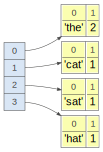

In [85]:
bag = [('the',2), ('cat',1), ('sat',1), ('hat',1)]
lolviz(bag)

That representation is a faithful representation of a bag of words, but looking up word frequencies is not efficient. To find a word, we must linearly scan the list of tuples looking for the word and then plucking out the frequency.

**Dictionaries**

To look up words quickly, we need to use a dictionary, which is really nothing more than a list of key-value associations. The big difference between a `list` of associations and a `dict` is their internal representation and speed of lookup. To create a dictionary from a list of associations is easy:

In [86]:
d = dict(bag)
print d

{'the': 2, 'sat': 1, 'hat': 1, 'cat': 1}


Python prints dictionaries out using `dict` literal notation, which we can use to define dictionaries directly:

{'the': 2, 'cat': 1, 'hat': 1, 'sat': 1}


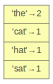

In [87]:
e = {'the': 2, 'sat': 1, 'hat': 1, 'cat': 1}
print e
lolviz(e)

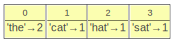

In [88]:
listviz(e.items()) # or we can view as a list of associations

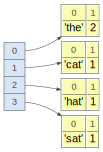

In [89]:
lolviz(e.items())  # or, at the lowest level, a list of lists

In implementation, however, dictionaries are actually more complicated than lists of associations in order to get the speed.

Accessing elements of the dictionary looks like array indexing except that the index is an arbitrary object, such as a string in our case:

In [90]:
print d['the']
print d['hat']
d['hat'] = 99    # alter the association
print d['hat']

2
1
99


Trying to access a key that does not exist in the dictionary causes a `KeyError` so it's best to check if the key exists first:

In [91]:
# print d['foo']     # This would cause a KeyError!
if 'cat' in d:       # hat is indeed in dictionary d
    print d['cat']
if 'foo' in d:       # does not exist so we don't get an error on the next line    
    print d['foo']   # does not execute

1


If you ever need a list of association representation of a dictionary, use function `items()`:

In [92]:
print d.items()

[('the', 2), ('sat', 1), ('hat', 99), ('cat', 1)]


Now that we know about associating words and word frequencies using dictionaries, we can try pulling apart a document into words.

## Tokenizing a document

Let's use an article on Istanbul as our text file and then figure out how to get an appropriate list of words out of it.

In [93]:
! head data/IntroIstanbul.txt


  
  
    
      
        The City and ITS People
        Istanbul is one of the worlds most venerable cities. Part
        of the citys allure is its setting, where Europe faces Asia acr­oss
        the winding turquoise waters of the Bosphorus, making it the only city
        in the world to bridge two continents.


In [Loading files](files.md), we learned how to read the contents of such a file into a string and split it on the space character:

In [94]:
f = open('data/IntroIstanbul.txt')
contents = f.read() # read all content of the file
f.close()
words = contents.split(' ')
print words[:25]    # print first 25 words

['\n', '', '\n', '', '\n', '', '', '', '\n', '', '', '', '', '', '\n', '', '', '', '', '', '', '', 'The', 'City', 'and']


As an exercise, we filtered out the empty strings `''` and newline strings `'\n'` using the filter pattern:

In [95]:
words = [w for w in words if len(w)>1]
print words[:25]

['The', 'City', 'and', 'ITS', 'People\n', 'Istanbul', 'is', 'one', 'of', 'the', 'worlds', 'most', 'venerable', 'cities.', 'Part\n', 'of', 'the', 'citys', 'allure', 'is', 'its', 'setting,', 'where', 'Europe', 'faces']


That looks more like it although it is still not very clean. Some of the words have `\n` or punctuation on the end and some words are capitalized.  What we need, though, is all words normalized so that `people` and `People` are consider the same word etc...

**Exercise**:  Implement another filter pattern to convert the words to lowercase using `lower()`. E.g., `'The'.lower()` is `'the'`.

Here's one way to do it:

In [96]:
words = [w.lower() for w in words]
print words[:25]

['the', 'city', 'and', 'its', 'people\n', 'istanbul', 'is', 'one', 'of', 'the', 'worlds', 'most', 'venerable', 'cities.', 'part\n', 'of', 'the', 'citys', 'allure', 'is', 'its', 'setting,', 'where', 'europe', 'faces']


**Exercise**:  Implement another filter pattern to get rid of the '\n' using `split()`. E.g., `'part\n'.strip()` gives 'part'.

Here's one way to do it:

In [97]:
words = [w.strip() for w in words]
print words[:25]

['the', 'city', 'and', 'its', 'people', 'istanbul', 'is', 'one', 'of', 'the', 'worlds', 'most', 'venerable', 'cities.', 'part', 'of', 'the', 'citys', 'allure', 'is', 'its', 'setting,', 'where', 'europe', 'faces']


That's not the best we can do, but it's good enough for the moment. 

## Computing word frequencies

Let's create a bag of words representation. My work plan would have a description like "Walk through the words in a document, updating a dictionary that holds the count for each word." The plan pseudocode would have a loop over the words whose body incremented a count in a dictionary

1. let wfreqs be an empty dictionary mapping words to word counts
2. for each word w in words:<br>if w not in wfreqs, let wfreqs[w] = 0.<br>Otherwise add one to wfreqs[w].

My code implementation would look like the following.

In [98]:
wfreqs = {}
for w in words:
    if w not in wfreqs: wfreqs[w] = 1
    else: wfreqs[w] = wfreqs[w] + 1
print wfreqs['ottoman']
print wfreqs['the']

4
123


Computing the frequency of elements in a list is common enough that Python provides a built-in data structure called a `Counter` that will do this for us:

In [99]:
from collections import Counter
wfreqs = Counter(words)
print wfreqs['ottoman']
print wfreqs['the']

4
123


That data structure is nice because it can give the list of, say, 10 most common words:

In [100]:
print wfreqs.most_common(10)

[('the', 123), ('of', 55), ('and', 40), ('to', 18), ('in', 16), ('is', 14), ('from', 9), ('most', 9), ('city', 8), ('this', 7)]


## Word clouds

Python has a nice library called `wordcloud` we can use to visualize the relative frequency of words. It should already be installed in your Anaconda Python directory, but if notm use the command line to install it:

```bash
$ pip install wordcloud
```

The key elements of the following code are the creation of the `WordCloud` and calling `fit_words()` with a dictionary (type `dict`) of word-freq associations, `wfreq`.

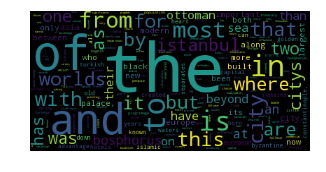

In [101]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud()
wordcloud.fit_words(wfreqs)

fig=plt.figure(figsize=(5, 3))   # Prepare a plot 5x3 inches
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

That's kind of busy will all of those words and there, so let's focus on the top 30 words. To do that we will call `most_common()`, which gives us a list of tuples. Because `fit_words()` it requires a `dict`, we converted the most common word list into a dictionary:

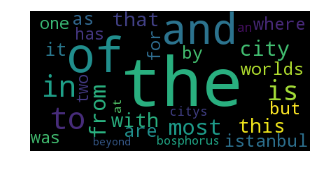

In [102]:
# Get 30 most common word-freq pairs then convert to dictionary for use by WordCloud
wtuples = wfreqs.most_common(30)
wdict = dict(wtuples)

wordcloud = WordCloud()
wordcloud.fit_words(wdict)

fig=plt.figure(figsize=(5, 3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

That looks better but it looks like common English words like "the" and "of" are dominating the visualization. To focus on the words most relevant to the document, let's filter out such so-called English *stop words*. [scikit-learn](http://scikit-learn.org/stable/), a machine learning library you will become very familiar with in future classes, provides a nice list of stop words we can use:

In [103]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
english = list(ENGLISH_STOP_WORDS) # Convert to a list so I can grab a subset
print english[:25]                 # Print 25 of the words

['all', 'six', 'less', 'being', 'indeed', 'over', 'move', 'anyway', 'fifty', 'four', 'not', 'own', 'through', 'yourselves', 'go', 'where', 'mill', 'only', 'find', 'before', 'one', 'whose', 'system', 'how', 'somewhere']


### Exercise 

Filter out the English stop words from the `words` list we computed above and reset `wfreqs` to a `Counter` based off this filtered list.

In [104]:
words = [w for w in words if w not in ENGLISH_STOP_WORDS]
wfreqs = Counter(words)
print wfreqs.most_common(10)

[('city', 8), ('worlds', 6), ('istanbul', 6), ('citys', 5), ('bosphorus', 5), ('ottoman', 4), ('sea', 4), ('important', 4), ('palace,', 3), ('asia', 3)]


### Exercise

Display a word cloud for `wfreqs`.

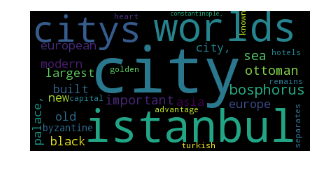

In [105]:
wtuples = wfreqs.most_common(30)
wdict = dict(wtuples)

wordcloud = WordCloud()
wordcloud.fit_words(wdict)

fig=plt.figure(figsize=(5, 3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

You can play around with the list of stop words to remove things like "largest" and others to really get the key words to pop out. There is a technique to automatically damp down common English words called [TFIDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which we will learn about in MSAN692 Data Acquisition.

## Summary

Text files are an unstructured data source that we typically represent as a bag of words. A bag of words representation is a set of associations mapping words to their frequency or count. We typically use a dictionary data structure for bag of words because dictionary lookup is extremely efficient, versus linearly scanning an entire list of associations. We used word clouds to visualize the relative frequency of words in a document. 

The data structures and techniques described in this lecture-lab form the basis of natural language processing (NLP).